**Add noise to images**

In [1]:
import sys
import os

In [2]:
import numpy as np

In [3]:
# Based on 
# https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv

def _prepare_img(img, copy=False):
    img_type = img.dtype
    if img_type in [np.uint8]:
        img = img / 255
    elif copy:
        img = img.copy()
    return img, img_type

def _restore_img(noisy, img_type):
    noisy = noisy.clip(0, 1)
    if img_type in [np.uint8]:
        noisy = (noisy*255).astype(img_type)
    return noisy    

def gaussian_noise(img, mean=0, sigma=.1):
    img, img_type = _prepare_img(img)
    noisy = (img + np.random.normal(mean, sigma, img.shape))
    return _restore_img(noisy, img_type)
    
def white_noise(img, mean=0, sigma=.1):
    img, img_type = _prepare_img(img)
    noisy = (img + -2 * sigma * np.random.random(img.shape) + sigma + mean)
    return _restore_img(noisy, img_type)

def salt_and_pepper_noise(img, ratio=.01, s_v_p=1):
    """Add salt (white) and pepper (black) noise
       to images.
       ratio = the ratio of points to change
       s_v_p = the ratio of salt v. pepper
       
    """
    
    noisy, img_type = _prepare_img(img, copy=True)
    amount = (
        noisy.shape[0] * noisy.shape[1] if len(noisy.shape) > 1 \
        else len(noisy)
    ) * ratio
    
    # Salt:
    num_salt = np.ceil(amount * s_v_p / (1 + s_v_p))
    coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in img.shape]
    noisy[coords] = 1
    
    # Pepper:
    num_pepper = np.ceil(amount / (1 + s_v_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in img.shape]
    noisy[coords] = 0
    
    return _restore_img(noisy, img_type)
   
def speckle_noise(img, mean=0, sigma=.1):
    img, img_type = _prepare_img(img)
    noisy = img + img * np.random.normal(mean, sigma, img.shape)
    return _restore_img(noisy, img_type)

def map_noise(imgs, noiser, **noiseargs):
    return np.array([noiser(img, **noiseargs) for img in imgs])

**Test**

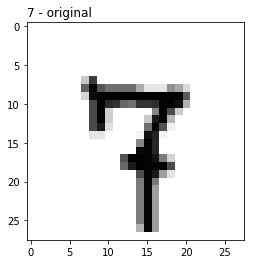

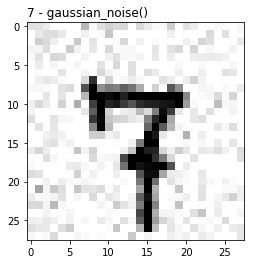

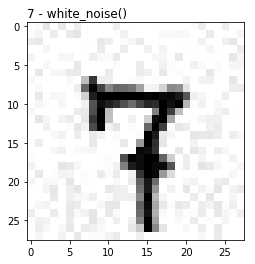

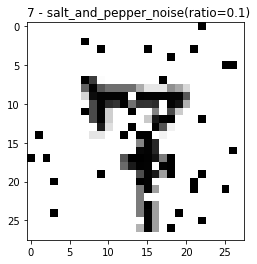

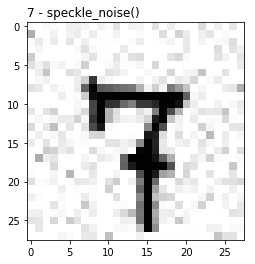

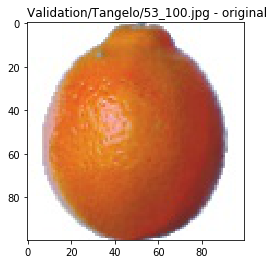

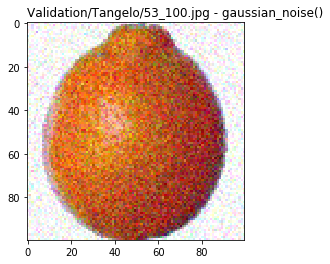

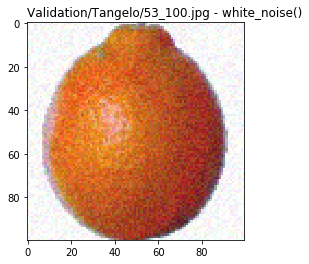

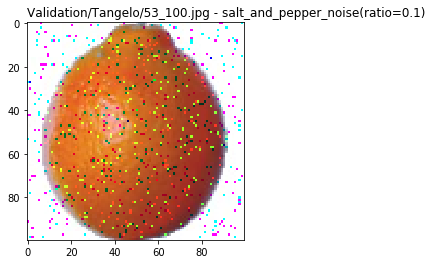

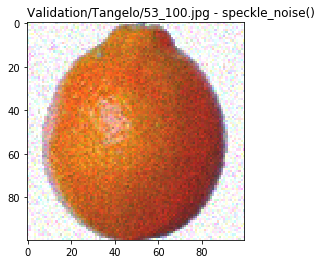

In [4]:
if __name__ == '__main__':
    import mnist_utils
    import pil_utils

    mnist_imgs = mnist_utils.load_image_file('data/mnist/t10k-images-idx3-ubyte.gz')
    mnist_labels = mnist_utils.load_label_file('data/mnist/t10k-labels-idx1-ubyte.gz')
    i = 987
    mnist_img, mnist_img_name = mnist_imgs[i], mnist_labels[i]
    
    pil_imgs = pil_utils.load_zip_archive('data/fruits-360/validation.zip',
                                          file_list='Validation/Tangelo/53_100.jpg')                                           
    pil_img, pil_img_name = pil_imgs[0]                                           
        
    noise_list = [
            None,
            gaussian_noise,
            white_noise,
            (salt_and_pepper_noise, dict(ratio=.1)),
            speckle_noise
    ]
    
    def plot_all(img, size=None, title=None):
        org_title = title
        for noise in noise_list:
            noiser, n_kwargs = \
                noise if type(noise) in [tuple] \
                else (noise, {})
            title = str(org_title) if org_title is not None else ''
            if title:
                title += ' - '
            n_args = ''
            for k, v in n_kwargs.items():
                if n_args:
                    n_args += ', '
                n_args += '{}={!r}'.format(k, v)
            title += 'original' if noiser is None \
                else '{}({})'.format(noiser.__name__, n_args)
            plot_img = img if noiser is None \
                else noiser(img, **n_kwargs)
            pil_utils.plot_image(plot_img, size=size, title=title)
        
    for img, size, title in [
        (mnist_img, 4, mnist_img_name),
        (pil_img, None, pil_img_name)
        ]:
        plot_all(img, size=size, title=title)